# ChIP AML PiPeline v2

In [4]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../..')
import itertools
from scipy import stats
import numpy as np

from JKBio.epigenetics import chipseq as chip
from JKBio.utils import helper, plot
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv
from collections import Counter

from scipy.special import factorial
from scipy.stats import fisher_exact

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [5]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [ ]:
%store -r merged
%store -r chrombed
%store -r mergedpeak
%store -r cols
%store -r annot
%store -r version
%store -r merging_version
%store -r window
%store -r crc

In [7]:
cols=8
annot=37

In [52]:
#getting the crcs
crc = helper.fileToList('../data/CRCs.txt')

## Doing Motif analysis

In [ ]:
! gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta ../../data/ref
! gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dict ../../data/ref

In [ ]:
gatk='java -jar ~/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar'

In [ ]:
#snps
! gsutil cp gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/f6f6b60e-cce8-45ef-aa4f-ef2a9c636ebe/Cram2FilteredVcf/4297eb57-caaa-4c7f-8d36-446174db724f/call-FilterVariantTranches/CDS-XBgVc6_cnn_filtered.vcf.gz ../temp/input_snp.vcf.gz
! gsutil cp gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/f6f6b60e-cce8-45ef-aa4f-ef2a9c636ebe/Cram2FilteredVcf/4297eb57-caaa-4c7f-8d36-446174db724f/call-FilterVariantTranches/CDS-XBgVc6_cnn_filtered.vcf.gz.tbi ../temp/input_snp.vcf.gz.tbi

In [ ]:
## computing motif across the open region of the genome of MV411 from ATACseq with MEME.mast
! mkdir ../../data/$project/MEME_$version/
! cp ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed && $gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O ../temp/middle.fasta -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed -V ../temp/input_snp.vcf.gz && fold ../temp/middle.fasta -w 500 > ../../data/$project/MEME_$version/ATAC.fasta

cmd = "export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme-5.1.1:$PATH && fimo --oc ../../data/"+project+"/MEME_"+version+"/ATAC/ ../../motif_databases/HUMAN/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme ../../data/"+project+"/MEME_"+version+"/ATAC.fasta"
! $cmd

! gff2bed < ../../data/$project/MEME_$version/ATAC/fimo.gff > ../../data/$project/MEME_$version/ATAC/fimo.gff.bed

In [ ]:
merged_motif = pd.read_csv('../../data/MEME/merged/fimo.gff.bed', sep='\t',skiprows=0,index_col=None, names=['pos', 'relstart', 'relend', "name", "strength","strand",'fimo','nucleotide_motif',".","data"])

merged_motif['tf'] = [i.split('_HUMAN')[0] for i in merged_motif.name]
merged_motif.relstart = merged_motif.relstart.astype(int)
merged_motif['start'] = [i.split(':')[1].split('-')[0] for i in merged_motif.pos]
merged_motif.start = merged_motif.start.astype(int)
merged_motif.relend = merged_motif.relend.astype(int)
merged_motif.start = merged_motif.start+merged_motif.relstart
merged_motif['end'] = merged_motif.start+merged_motif.relend
merged_motif['chrom'] = [i.split(':')[0][3:] for i in merged_motif.pos]


In [93]:
rn={'HOXA9':'HXA9',
 'SREBF1':'SRBP1',
 'STAT5B':'STA5B',
 'ZEB2':"ZEB1",
 'ZNF281':'ZN281'}
proteins = []
for i in merged.columns[cols:]:
    for k,v in rn.items():
        i = i.replace(k,v)
    proteins.append(i)
set(proteins) - set(merged_motif.tf)

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'LDB1',
 'LMO2',
 'MED1',
 'MLL_KTM2A',
 'MYBL2',
 'PLAGL2',
 'POLII',
 'PSER2',
 'SMC1',
 'WDR5',
 'ZMYND8',
 'activation',
 'repression',
 'super_enhancer'}

In [94]:
merged_motif = merged_motif[merged_motif.tf.isin(proteins)]
merged_motif['pval'] = [float(i.split('pvalue=')[1].split(';')[0]) for i in merged_motif.data]
merged_motif['seq'] = [i.split('sequence=')[1].split(';')[0] for i in merged_motif.data]
merged_motif = merged_motif[['chrom', 'start', 'end', "strength", 'pval','strand', 'tf','seq']].sort_values(by=['chrom','start','strength']).reset_index(drop = True)
merged_motif = merged_motif.rename(columns={'chr':'chrom'})
merged_motif.chrom = "chr"+merged_motif.chrom
merged_motif.chrom = merged_motif.chrom.astype(str)

<ipython-input-94-fa174bf48da8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_motif['pval'] = [float(i.split('pvalue=')[1].split(';')[0]) for i in merged_motif.data]
<ipython-input-94-fa174bf48da8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_motif['seq'] = [i.split('sequence=')[1].split(';')[0] for i in merged_motif.data]


KeyError: "['end'] not in index"

In [97]:
a = {}
for k,v in rn.items():
    a[v] = k 
rn = a
merged_motif['tf'] = merged_motif['tf'].replace(rn)

In [98]:
merged_motif = merged_motif.rename(columns={'strength':"foldchange"})

In [99]:
merged_motif

,chrom,start,end,foldchange,pval,strand,tf,seq
0,chr1,10282,10707,40.5,0.000090,-,RUNX2,GGGTTGGGGTTAGG
1,chr1,10288,10719,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
2,chr1,10294,10731,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
3,chr1,10300,10743,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
4,chr1,10306,10755,41.6,0.000069,-,RUNX2,GGGTTGGGGTTGGG
...,...,...,...,...,...,...,...,...
2241485,chrY,56876566,56876635,56.1,0.000002,-,SPI1,GGATAGCGGAAGTGAAA
2241486,chrY,56876568,56876635,52.9,0.000005,-,ELF2,ATAGCGGAAGTGA
2241487,chrY,56876668,56876833,46.0,0.000025,-,MYC,GCCATGTGTTT
2241488,chrY,56878627,56878678,45.3,0.000030,+,GATA2,AAAGATAAGAG


In [22]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [100]:
merged_motif.to_csv('../results/'+project+'/large/'+version+'_merged_motif.bed.gz', sep='\t')

In [5]:
merged_motif = pd.read_csv('../results/'+project+'/large/'+version+'_merged_motif.bed.gz', sep='\t')

In [26]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_annotations.bed.gz', sep='\t')

## what motifs map to their right binding event

In [71]:
set(merged.columns)

{'-log10pvalue',
 '-log10qvalue',
 'AFF4',
 'ATAC',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPA_mot',
 'CEBPB',
 'CEBPB_mot',
 'CTCF',
 'CTCF_mot',
 'E2F3',
 'E2F3_mot',
 'ELF2',
 'ELF2_mot',
 'ETV6',
 'ETV6_mot',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FLI1',
 'FLI1_mot',
 'FOSL2',
 'FOSL2_mot',
 'FOXP1',
 'FOXP1_mot',
 'GATA2',
 'GATA2_mot',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'HOXA9_mot',
 'IKZF1',
 'IKZF1_mot',
 'IRF8',
 'IRF8_mot',
 'JUND',
 'JUND_mot',
 'LDB1',
 'LMO2',
 'LYL1',
 'LYL1_mot',
 'MAX',
 'MAX_mot',
 'MED1',
 'MEIS1',
 'MEIS1_mot',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYB_mot',
 'MYC',
 'MYC_mot',
 'PLAGL2',
 'POLII',
 'PSER2',
 'RARA',
 'RARA_mot',
 'RUNX1',
 'RUNX1_mot',
 'RUNX2',
 'RUNX2_mot',
 'RXRA',
 'RXRA_mot',
 'SMC1',
 'SP1',
 'SP1_mot',
 'SRBP1_mot',
 'SREBF1',
 'STAT5B',
 'STAT5B_mot',
 'TFAP4',
 'TFAP4_mot',
 'WDR5',
 'ZEB2',
 'ZEB2_mot',
 

In [27]:
for val in set(merged_motif.tf):
    merged[val+'_mot'] = chip.putInBed(merged[merged.columns[:cols]], merged_motif[merged_motif.tf==val], window=100)
merged = merged.replace(np.nan,0)

66657 were merged into conscensus
31271 were merged into conscensus
32285 were merged into conscensus
27531 were merged into conscensus
27714 were merged into conscensus
37343 were merged into conscensus
56274 were merged into conscensus
35206 were merged into conscensus
23331 were merged into conscensus
57865 were merged into conscensus
33019 were merged into conscensus
20639 were merged into conscensus
23950 were merged into conscensus
44996 were merged into conscensus
34847 were merged into conscensus
94374 were merged into conscensus
37051 were merged into conscensus
24886 were merged into conscensus
35416 were merged into conscensus
21410 were merged into conscensus
28460 were merged into conscensus
18652 were merged into conscensus
30756 were merged into conscensus
21322 were merged into conscensus
16499 were merged into conscensus
51147 were merged into conscensus
46342 were merged into conscensus
34280 were merged into conscensus
105158 were merged into conscensus
44487 were me

In [29]:
merged.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_motifs.bed.gz', sep='\t')

### computing frequency binding of a motif with its TF.

barplot of the percentage of peaks that overlap with Motifs found for the same TF. peaks are found with MACS2. We are only looking at Motifs on the regions defined by the cobinding matrix: (regions with at least 2 CRC TF cobinding).

In [114]:
a = []
b = []
for val in set(merged.columns[8:]):
    if '_mot' in val:
        b.append(val[:-4])
        a.append(merged[merged[val]!=0][val[:-4]].astype(bool).sum() / merged[val[:-4]].astype(bool).sum())

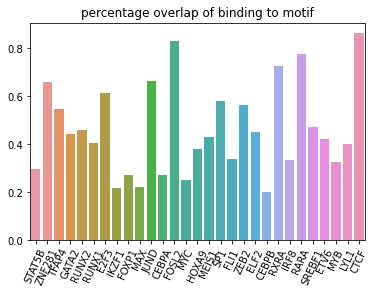

In [115]:
sns.barplot(data=pd.DataFrame(data = a, index=b, columns=['counts']).T)
plt.xticks(rotation=65)
plt.title("percentage overlap of binding to motif")
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/percentage_overlap_binding2motif.pdf")

In [118]:
np.mean(a)

0.46220848463486913

In [98]:
mergedmot = merged
%store mergedmot

Stored 'mergedmot' (DataFrame)


In [3]:
%store -r mergedmot

## Unbound Open region Motifs:

What are the motifs of our CRC members in ATACseq but not in our matrix


In [99]:
overlap = [25208, 54903, 24089, 65091, 33666, 42825, 32539, 16402, 20276, 14741, 21896, 100287, 18913, 24846, 25447, 89784, 43004, 35733, 33211, 27676, 45552, 55072, 42383, 32933, 23000, 30475, 31295, 27557, 75131]

In [102]:
merged_motif['tf'] = merged_motif.tf.replace({"SRBP1":"SREBF1","HXA9":"HOXA9"})

In [103]:
a = []
b = []
for i, val in enumerate([i[:-4] for i in mergedmot.columns[72:]]):
    b.append(val)
    a.append(overlap[i] / (merged_motif.tf==val).sum())

NameError: name 'overlap' is not defined

barplot of the percentage of Motifs for a specific TF that are bound by this TF. Motifs are found with MEME on Open chromatin region. A TF is considered bound if it has a peak at that region.

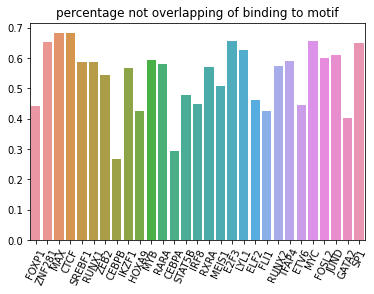

In [112]:
sns.barplot(data=pd.DataFrame(data = a, index=b, columns=['counts']).T)
plt.xticks(rotation=65)
plt.title("percentage not overlapping of binding to motif")
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/percentage_nonoverlap_binding2motif.pdf")

In [5]:
mergedmot.columns[8:37]

Index(['CEBPA', 'HOXA9', 'PLAGL2', 'MEIS1', 'ETV6', 'HEX', 'FLAG_GFI1',
       'RUNX1', 'FOSL2', 'FLI1', 'GATA2', 'SP1', 'E2F3', 'ZNF281', 'SREBF1',
       'LMO2', 'STAT5B', 'ZMYND8', 'FLAG_MEF2C', 'LYL1', 'MYC', 'TFAP4',
       'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'FLAG_MEF2D'],
      dtype='object')

## regulatory code: 

For each TF with known motifs, we look at the set of possible sets of cobinding CRC TF. for each set we compute its enrichment. we then display the most enriched sets 

Issue: Due to the exponential complexity of computing each possible pvalues, we do not, the test is thus not BH corrected when it is on a set of $\sum_{k = 2..10} {29 \choose k}$ possible realizations: 36,519,526 and it is not chosen  randomly 

In [123]:
from scipy.special import comb
suma=0
for i in range(2,11):
    suma += comb(29,i)
int(suma)

36519526

In [32]:
#@jit(parallel=True)
#TODO: chisquare tests except when the number in contingency is below a certain value
def compfish(e, proba, size1, size2):
    folds = {}
    pvals = {}
    i=0
    for k, v in e.items():
        if len(k)<9 and v>100:
            a = np.prod(proba[list(k)])#*factorial(len(k))
            if (a / size1) * 1.2 < v / size2:
                a = int(a*size2)
                i+=1
                fold, p = fisher_exact([[size1-a,a],[size2-v,v]])
                folds[fold] = np.log2(k)
                pvals[k] = p
    print(i)
    return folds, pvals

In [ ]:
## what enrichment do we have in each group? what enrichment do we have for each ChipSeq?
res = {val: {} for i, val in enumerate([i[:-4] for i in mergedmot.columns[72:]])}
proba = mergedmot[mergedmot.columns[8:37]].astype(bool).sum()/len(mergedmot)
for i, val in enumerate([i[:-4] for i in mergedmot.columns[72:]]):
    a,b = np.where(mergedmot[(mergedmot[val]!=0)][mergedmot.columns[8:37]]!=0) #72
    e = []
    u = []
    preva=a[0]
    print('_________________')
    print(val)
    for i, v in enumerate(a):
        n = mergedmot.columns[8+b[i]]
        if n == val or n=="CEBPA":
            continue
        # we are still on the same row
        if v == preva:
            u.append(n)
            e.append(tuple(u))
        # we moved
        else:
            e.append(tuple(u))
            u = [n]
        preva = v
    e = Counter(e)
    s = len(set(a))
    d,f = compfish(dict(e), proba, len(mergedmot), s)
    #    v = (v/s)*100
    #    if v >5:
    #        d[v] = k
    a = list(d.keys())
    a.sort()
    for v in a[::-1]:
    #    print("%.2f%% for: %s" % (v, str(d[v])))
        if v>4:
            print("%.2f,%.2f for: %s" % (v, f[d[v]], str(d[v]), ))
        res[val][d[v]] = (v, f[d[v]])

In [64]:
helper.dictToFile(helper.stringifydict(res),"../results/"+project+"/"+version+"_"+window+"_cobinding_code_nomotif_filter.json")

In [238]:
for k,v in res.items():
    print('______________________')
    print(k)
    for i,j in v.items():
        a = np.log2(j[0])
        if a>4:
            print("%.2f,%.2f for: %s" % (a, j[1], str(i)))

______________________
FOXP1
4.37,0.00 for: ('HOXA9', 'MEIS1', 'RUNX1', 'FLI1')
4.33,0.00 for: ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'GATA2')
4.28,0.00 for: ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1')
4.26,0.00 for: ('MEIS1', 'RUNX1', 'FLI1', 'SP1', 'STAT5B', 'ZMYND8')
4.25,0.00 for: ('MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'ZNF281')
4.20,0.00 for: ('MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'STAT5B')
4.18,0.00 for: ('MEIS1', 'RUNX1', 'FLI1', 'LMO2', 'STAT5B', 'ZMYND8')
4.14,0.00 for: ('MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'STAT5B', 'ZMYND8')
4.03,0.00 for: ('RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281')
inf,0.00 for: ('PLAGL2', 'MEIS1', 'ETV6', 'RUNX1', 'FOSL2', 'FLI1', 'SP1')
11.69,0.00 for: ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3')
11.35,0.00 for: ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281')
10.24,0.00 for: ('PLAGL2', 'MEIS1', 'ETV6', 'RUNX1', 'FLI1', 'SP1')
10.12,0.00 for: ('PLAGL2', 'MEIS1', 'ETV6', 'FLAG_GFI1', 'RUNX1', 'FLI1')
9.95,0.00 for: 

### computing motif enrichment for each TF

In [30]:
enr, pvals = chip.enrichment(merged)

../../JKBio/epigenetics/chipseq.py:1093: RuntimeWarning: divide by zero encountered in log2
  enrichment[i, j+add] = np.log2(e)


In [229]:
enr.loc["SP1_mot"]["RXRA_mot"], enr.loc["RXRA_mot"]["SP1_mot"]

(1.2307105392373137, 2.2138321299825496)

In [230]:
len(merged[merged["RXRA_mot"]!=0]),len(merged),len(merged[merged["SP1_mot"]!=0])

(53836, 142970, 21135)

In [139]:
motloc = 59

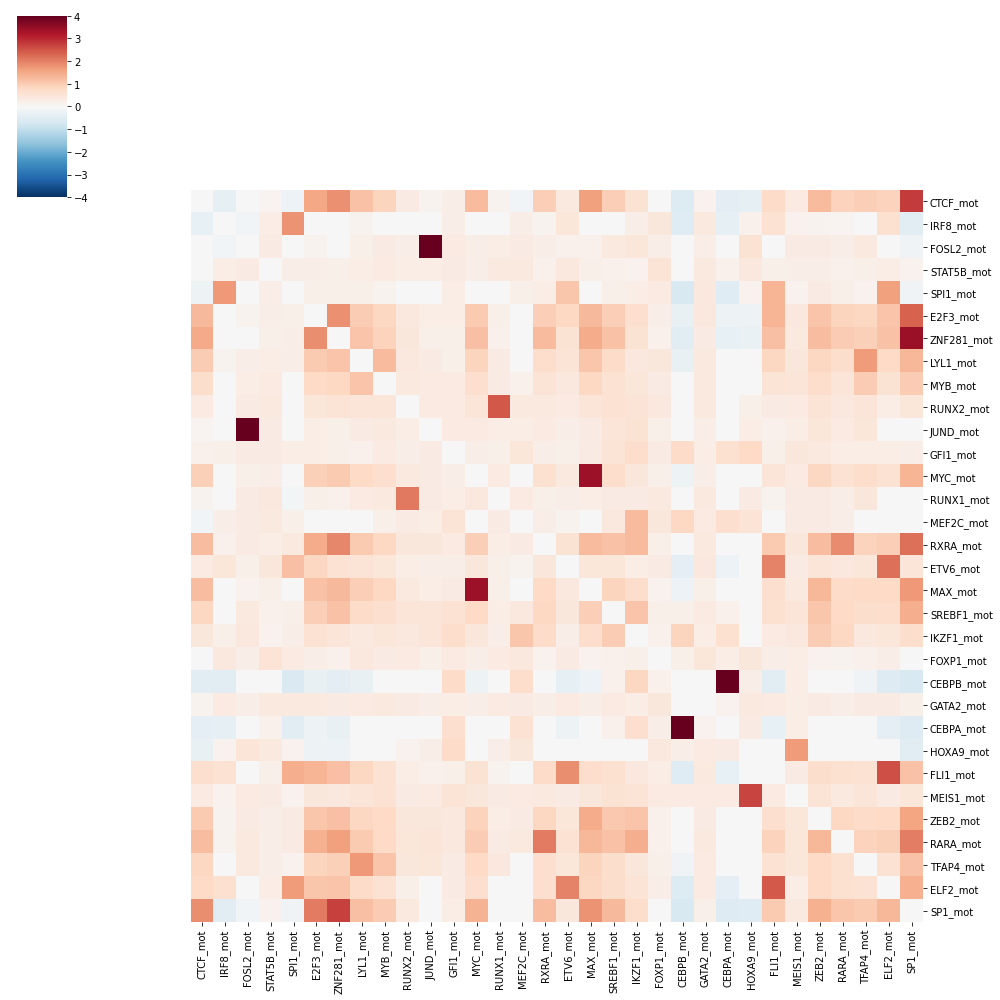

In [33]:
# enrichment for each motifs
fig = sns.clustermap(enr.iloc[motloc:][enr.columns[motloc:]],figsize=(14,14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_ofmotifs_on_motifs.pdf')
plt.show()

In [ ]:
len(merged[merged['CTCF']!=0]), len(merged[merged['MEF2C_mot']!=0]), len(merged[merged['SP1']!=0]), len(merged[merged['SP1']!=0])

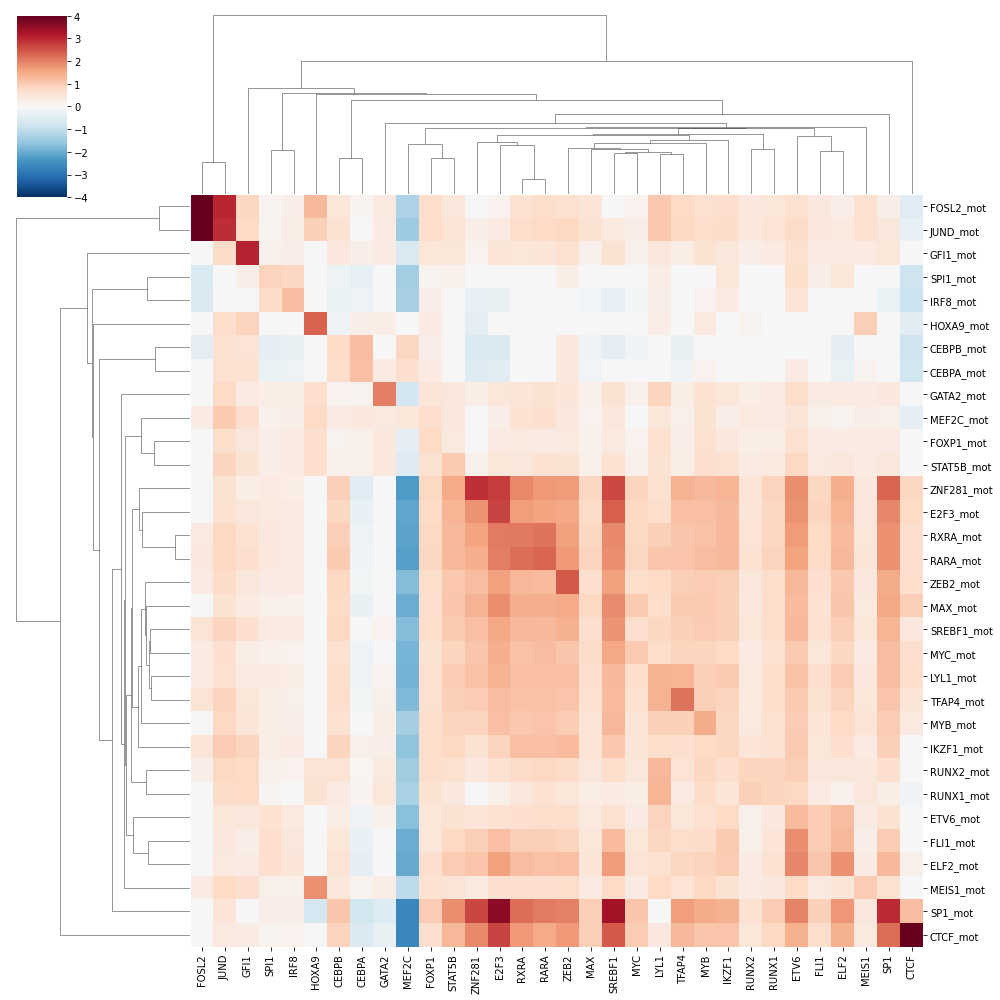

In [34]:
# enrichment for each tf signal on associated motifs
data = enr.loc[enr.columns[motloc:]][[i.split('_')[0] for i in enr.columns[motloc:]]]
link = linkage(data, optimal_ordering=True)
fig = sns.clustermap(data, figsize=(14,14), row_linkage=link, col_linkage=link, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_crc_tfs_onmotifs.pdf')
plt.show()

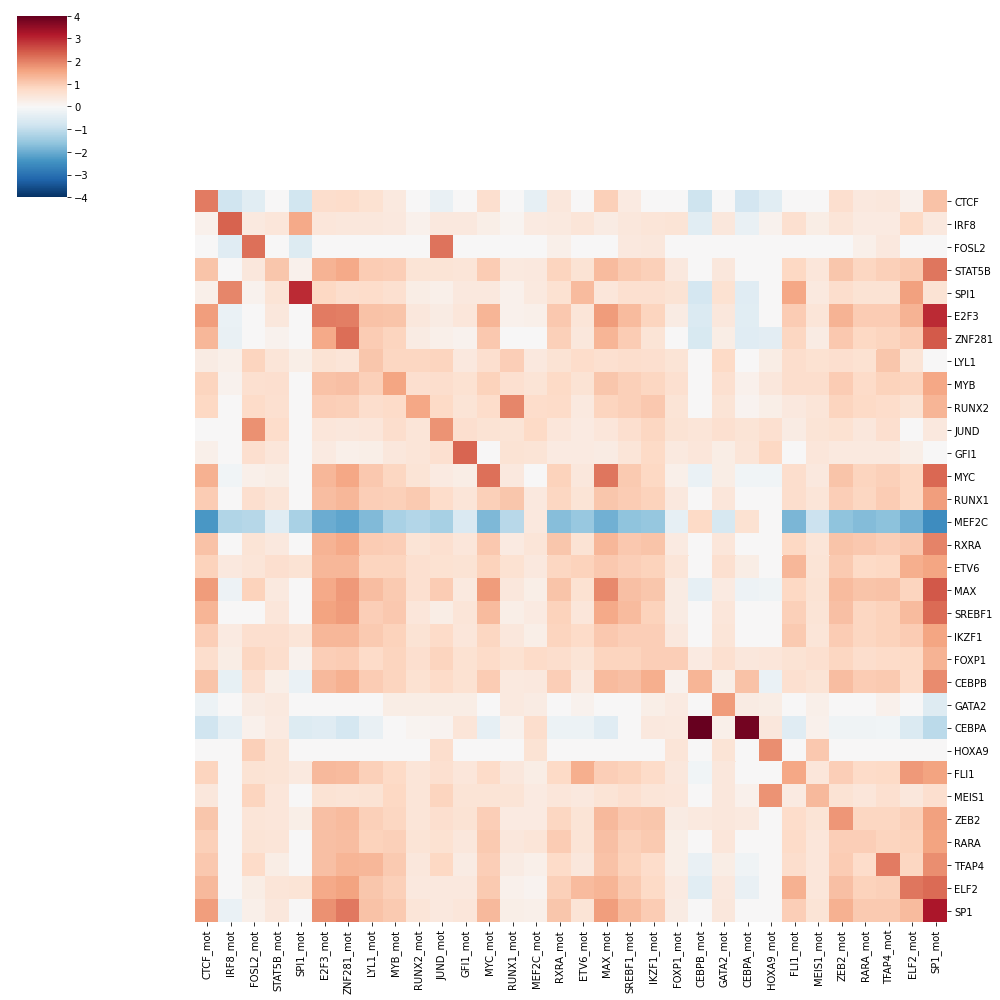

In [35]:
# enrichment for each motifs on associated tf signal
fig = sns.clustermap(enr.loc[[i.split('_')[0] for i in enr.columns[motloc:]]][enr.columns[motloc:]], figsize=(14,14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_ofmotifs_on_crc_tfs.pdf')
plt.show()

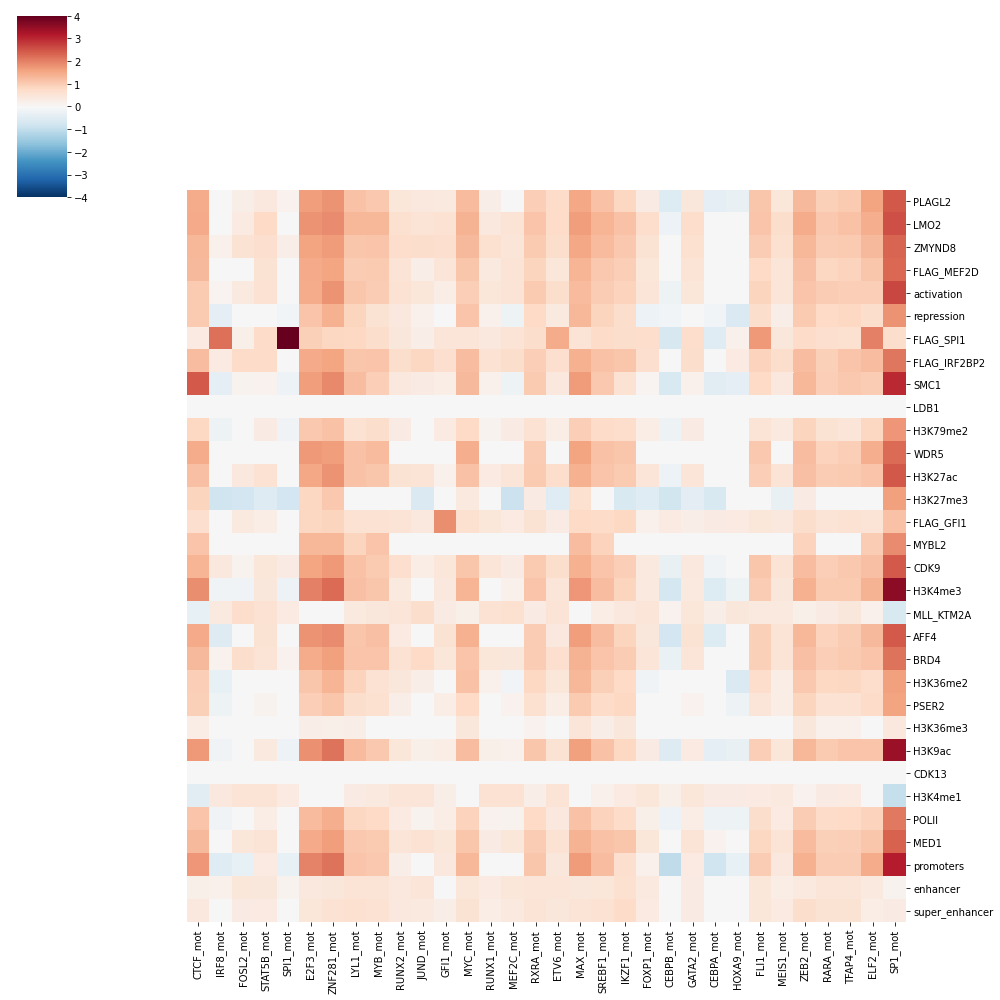

In [36]:
# enrichment on non motif peaks
fig = sns.clustermap(enr.loc[[i for i in enr.columns[:motloc] if i+'_mot' not in enr.columns[63:]]][enr.columns[motloc:]],figsize=(14, 14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_ofmotifs_on_non_motif_tfs.pdf')
plt.show()

In [46]:
# enrichment on non motif peaks
data = enr.loc[enr.columns[motloc:]][[i for i in enr.columns[:motloc] if i+'_mot' not in enr.columns[motloc:]]]
fig = sns.clustermap(data,figsize=(14, 14), row_cluster=0, col_cluster=0, vmax=4, vmin=-4, cmap='RdBu_r')
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/enrichment_of_non_motif_tfs_onmotifs.pdf')
plt.show()

KeyError: "None of [Int64Index([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,\n            81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,\n            98, 99],\n           dtype='int64')] are in the [index]"

### Computing motif enrichment in chip clusters

In [10]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [38]:
%store -r cols
%store -r annot

In [11]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_motifs.bed.gz', sep='\t')

In [39]:
data= merged[merged.columns[cols:annot]].values
scaled_data = (data-data.min(0))/(data.max(0)-data.min(0))

In [165]:
n = 3
n_clust=[10,20,50,100,200]
kmean = KMeans(n_clusters=n_clust[n],n_jobs=8)
groups = kmean.fit_predict(scaled_data)

In [166]:
np.save('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_clusters.npy', groups)

In [167]:
enr, pvals = chip.enrichment(merged, groups=groups)

In [170]:
enr.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/kmeans_'+str(n_clust[n])+'_enrichments_on_all_peaks.csv')

Heatmap showing the enrichment in binding motifs for a specific TF of each clusters. Clusters were computed from clustering the peaks of the cobinding matrix based on the scaled signal of each TF. Enrichment are computed from a fisher exact test on expected overlap compared to observed overlap. pvalues are corrected for mutiple hypothesis testing using the BH method. only enrichment with an adjusted pval<0.001 are reported

In [127]:
rm = ["FLAG_IRF2BP2", "GFI1", "FLAG_SPI1", "activation", "repression"]

In [129]:
merged = merged.drop(columns=rm)

In [130]:
l = merged.columns.tolist()
l.remove("FLAG_GFI1")
merged = merged[l[:cols]+["FLAG_GFI1"] + l[cols:]]

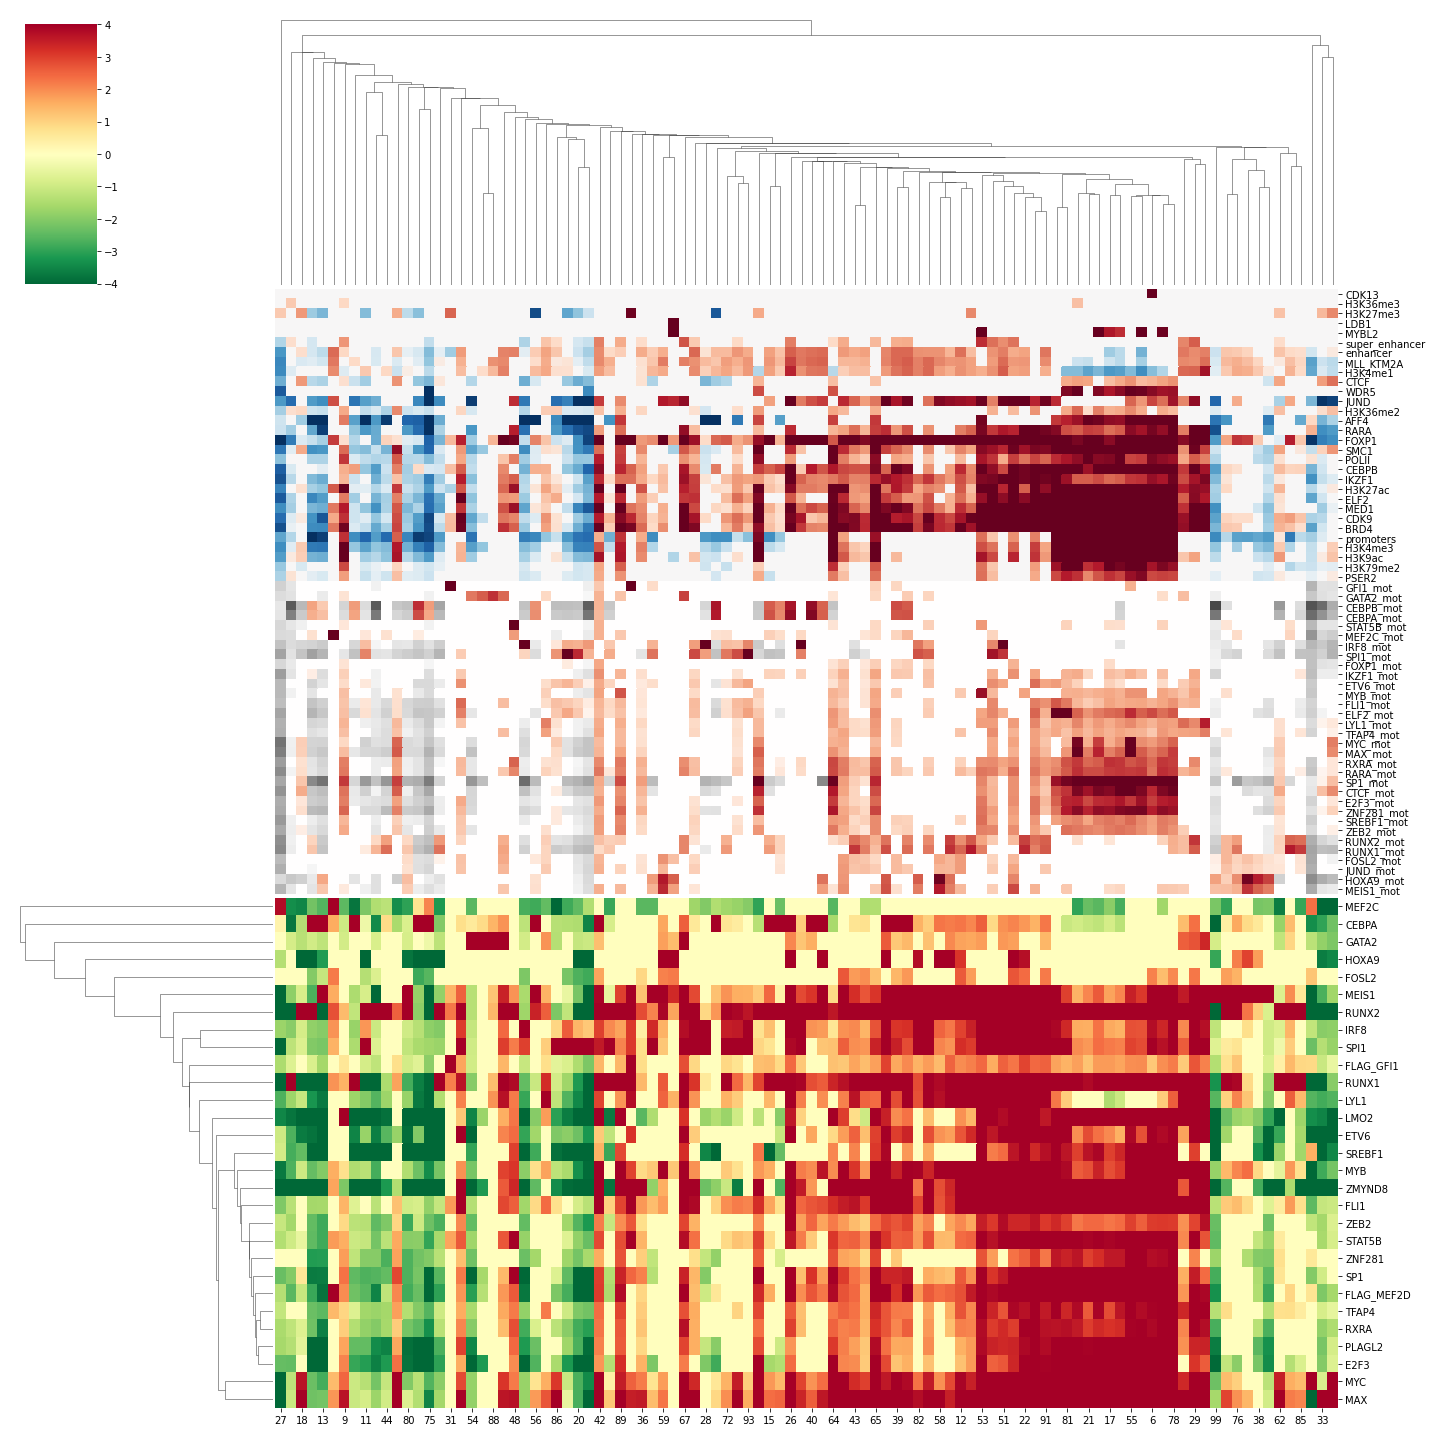

In [168]:
maxv=4
rdb = cm.get_cmap('RdBu_r', 256)
rdy = cm.get_cmap('RdGy_r', 256)
vals = merged.columns[cols:annot]
col = enr.loc[merged.columns[annot:]].copy().T
col[col<-maxv]=-maxv
col[col>maxv]=maxv
col = col/maxv
collink = linkage(enr.loc[merged.columns[cols:annot]].T)
rowlink = linkage(enr.loc[merged.columns[cols:annot]], metric="cosine")
rowlinkMot = linkage(enr.loc[merged.columns[annot:motloc+8]], metric="cosine")
rowlinkAdd = linkage(enr.loc[merged.columns[motloc+8:]], metric="cosine")
for val in merged.columns[annot:motloc+8].tolist():
    col[val] =[rdb(128+int(v*128)) for v in col[val]]
for val in merged.columns[motloc+8:].tolist():
    col[val] =[rdy(128+int(v*128)) for v in col[val]]
col = col[[col.columns[i] for i in list(leaves_list(rowlinkMot)) + list(len(leaves_list(rowlinkMot)) + leaves_list(rowlinkAdd))]]
fig = sns.clustermap(enr.loc[merged.columns[cols:annot]], figsize=(20,20), vmax=4, vmin=-4, cmap='RdYlGn_r', col_colors=col, colors_ratio=0.007, col_linkage=collink, row_linkage=rowlink)
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/motifs_and_crc_enrichment_on_clusters_'+str(n_clust[n])+'.pdf')
plt.show()

## Simple predictions

In [60]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
import pickle

In [96]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(), )),
  ('classification', RandomForestClassifier())
])

features = {}
tests = {}
clfs= {}

data = merged[merged.columns[cols:annot]].values
#data = ((data.T - data.min(1)) / (data.max(1) - data.min(1))).T
data = data.astype(bool)
for val in range(data.shape[1]):
    print(val, end='\r')
    names = merged.columns[cols:annot].tolist()
    names.remove(k)
    size = len(merged[merged[merged.columns[cols+val]]==0])
    if size<1000:
        neg = 2000
        pos = 1000
    elif size< 10000:
        x = int(size/1000)
        neg = x*2000
        pos = x*1000
    else:
        neg = 20000
        pos = 10000 
    
    train = np.append(data[np.random.choice(merged[merged[merged.columns[cols+val]]!=0].index, neg)], data[np.random.choice(merged[merged[merged.columns[cols+val]]==0].index, pos)],0)

    cl = clf.fit(np.delete(train,val,1), train[:,val])
    
    clfs[merged.columns[cols+val]] = pickle.dumps(clf.get_params()['classification'])
    features[merged.columns[cols+val]] =  [np.array(names)[cl['feature_selection'].get_support()].tolist(), cl['classification'].feature_importances_.tolist()]
    
    test = np.append(data[np.random.choice(merged[merged[merged.columns[cols+val]]!=0].index,500)], data[np.random.choice(merged[merged[merged.columns[cols+val]]==0].index, 500)],0)
    
    tests[merged.columns[cols+val]] = clf.score(np.delete(test,val,1), test[:, val])

In [ ]:
### DT 60,000

In [97]:
tests

{'FLAG_GFI1': 0.669,
 'CEBPA': 0.631,
 'HOXA9': 0.758,
 'PLAGL2': 0.827,
 'MEIS1': 0.666,
 'ETV6': 0.799,
 'RUNX1': 0.764,
 'FOSL2': 0.724,
 'FLI1': 0.706,
 'GATA2': 0.63,
 'SP1': 0.77,
 'E2F3': 0.86,
 'ZNF281': 0.723,
 'SREBF1': 0.852,
 'LMO2': 0.865,
 'STAT5B': 0.77,
 'ZMYND8': 0.896,
 'LYL1': 0.792,
 'MYC': 0.78,
 'TFAP4': 0.715,
 'RUNX2': 0.706,
 'MAX': 0.775,
 'IRF8': 0.71,
 'MYB': 0.783,
 'ZEB2': 0.712,
 'RXRA': 0.767,
 'SPI1': 0.725,
 'MEF2C': 0.827,
 'FLAG_MEF2D': 0.76}

In [98]:
for k, v in tests.items():
    a = merged.columns[cols:annot].tolist()
    a.remove(k)
    print("______________________")
    print(k, v)
    print(features[k])
    ## SHOW TREE
    #plt.figure(figsize=(20,20))
    #_ = plot_tree(pickle.loads(clfs[k]), label="root", feature_names=a, class_names=["False", "True"], impurity=False, filled=True)
    #plt.show()

______________________
FLAG_GFI1 0.669
[['CEBPA', 'MEIS1', 'RUNX1', 'STAT5B', 'TFAP4', 'IRF8', 'MYB'], [0.035244617049911976, 0.07437984918481395, 0.2938640868182479, 0.3405363219169892, 0.10867340057785992, 0.04393844423284939, 0.1033632802193277]]
______________________
CEBPA 0.631
[['CEBPA', 'RUNX1', 'FLI1', 'SP1', 'ZNF281', 'STAT5B', 'MYC', 'TFAP4', 'MAX', 'IRF8', 'SPI1', 'MEF2C'], [0.051301358634221535, 0.11139846402897664, 0.07544076739231224, 0.06076845647214747, 0.07480111400542606, 0.06446897805707293, 0.09688951763425867, 0.0722646372768709, 0.09141779685946846, 0.12143761960038173, 0.11389747476755702, 0.06591381527130648]]
______________________
HOXA9 0.758
[['MEIS1', 'FLI1', 'GATA2', 'LYL1', 'MYB'], [0.496078381569486, 0.039730422430765897, 0.07075787162224502, 0.16063743840657838, 0.23279588597092452]]
______________________
PLAGL2 0.827
[['SP1', 'STAT5B', 'MAX'], [0.37200665290251594, 0.39224414085883, 0.2357492062386541]]
______________________
MEIS1 0.666
[['HOXA9', 'R

In [ ]:
### RF: 60,000

In [13]:
for k, v in tests.items():
    a = merged.columns[cols:annot].tolist()
    a.remove(k)
    print("______________________")
    print(k, v)
    print(np.array(a)[fit[k]['feature_selection'].get_support()].tolist())
    print(fit[k]['classification'].feature_importances_.tolist())

______________________
FLAG_GFI1 0.862
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
CEBPA 0.674
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
HOXA9 0.995
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
PLAGL2 0.937
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
MEIS1 0.751
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
ETV6 0.95
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
RUNX1 0.78
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.3701571733429585]
______________________
FOSL2 0.965
['ZNF281', 'STAT5B', 'LYL1']
[0.2806595434427988, 0.34918328321424275, 0.37015717

In [ ]:
30,000

In [221]:
tests

{'FLAG_GFI1': 0.831,
 'CEBPA': 0.684,
 'HOXA9': 0.983,
 'PLAGL2': 0.926,
 'MEIS1': 0.748,
 'ETV6': 0.943,
 'RUNX1': 0.799,
 'FOSL2': 0.976,
 'FLI1': 0.763,
 'GATA2': 0.922,
 'SP1': 0.885,
 'E2F3': 0.927,
 'ZNF281': 0.885,
 'SREBF1': 0.962,
 'LMO2': 0.932,
 'STAT5B': 0.851,
 'ZMYND8': 0.917,
 'LYL1': 0.911,
 'MYC': 0.786,
 'TFAP4': 0.842,
 'RUNX2': 0.756,
 'MAX': 0.796,
 'IRF8': 0.699,
 'MYB': 0.876,
 'ZEB2': 0.941,
 'RXRA': 0.931,
 'SPI1': 0.716,
 'MEF2C': 0.952,
 'FLAG_MEF2D': 0.889}

## QCing and motif discovering chips with MEME-chip

In [ ]:
## computing predicted motif for each TF from Chip data MEME-Chip
## computing motif across the open region of the genome of MV411 from ATACseq with MEME.mast

    ! mkdir ../../data/$project/MEME_$version/
    ! cp ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed && $gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O ../temp/middle.fasta -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed -V ../temp/input_snp.vcf.gz && fold ../temp/middle.fasta -w 500 > ../../data/$project/MEME_$version/$chip.fasta

    cmd = "export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme-5.1.1:$PATH && meme-chip --oc ../../data/"+project+"/MEME_"+version+"/"+chip+"/ -db ../../motif_databases/HUMAN/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme ../../data/"+project+"/MEME_"+version+"/"+chip+".fasta"
    ! $cmd

    ! gff2bed < ../../data/$project/MEME_$version/$chip/fimo.gff > ../../data/$project/MEME_$version/$chip.gff.bed

In [ ]:
## comparing with the litterature using MEME.tomtom


## Assigning genes

### based on closest expressed gene

In [ ]:
chiphelper.AssignToClosestExpressed()

In [ ]:
### recompute cobinding based on this.

In [ ]:
## redo the plots. do we get better plots?/correlations?...

### based on the ABC model

![](images/ABCtitle.png)

They tested a new model based on and validated by CRISPRi-FlowFISH which is basically able to find enhancer mapping to genes. 
They used it to compute their model's Accuracy and found a 70% accuracy compared to less than 50% for closest expressed gene. 

Way to integrate our HiC data (need ATAC-seq like data as well, but openly available) 


![](images/ABCmodel.png)

In [ ]:
Helper.scatter(TSNE(2,5).fit_transform(data.T), labels=zones.columns[11:],colors=labels)

In [ ]:
### recompute cobinding based on this.

In [ ]:
### redo the plots. do we get better looking plots?

In [ ]:
### compare presence of CTCF and transcription of linked RNA

## Predict

In [ ]:
## enrichment at the gene set level

In [ ]:
## are our cobinding clusters enriched in some sets of genes / CRC? 

In [ ]:
## make a linear model to with marks and cobinding data + motifs and TFs+cobinding motifs + expression of cobound proteins + expression , can we predict expression/dependenccy?

In [ ]:
## can we predict better for some set of genes / CRCs?

In [ ]:
## do the same on closest expressed gene

In [ ]:
## do this prediction on each enhancer.what is the best predicting enhancer? do that correlate with ABC model data?

In [ ]:
## do we get, for some gene, better single enhancer prediction?

In [ ]:
## what are the gene sets enriched in each clusters?? (based on TF cobinding or based on TF cobinding + )

## RNP data

In [ ]:
## can we predict RNP data (setting this TF to zero and lookingg at expected RNA change)
## do we see genes with opposite effects? 

In [ ]:
## if we add RNP data, can we increase our model's prediction? (we have expression change and we set all RNPed-TF values to 0) 

In [ ]:
### to predict remaining X% RNA expression
### to predict remaining X TFs RNP
### to predict regular RNA expression

In [ ]:
## same thing with filtering base on motif presence (actual DNA binding)
## same thing with closest expressed gene

In [ ]:
## Do on all cell lines

In [ ]:
## repeat the process across all samples with H3K27ac+RNAseq data we have.

In [ ]:
## call mutations from H3k27ac data

In [ ]:
## MEME analysis of likely bound TFs, except if TF is not expressed

In [ ]:
## compute enrichments

In [ ]:
## from same gene assignements, as found on the general consensus peak set, can we find good dependency/expression prediction

### Compare data with other labs (H3K27, HiC..)

we need to redo everything for similar normal cell type, getting TFs based on the CRC (find it with CRCmapper or on litterature)